# Antipodal Grasp with Deep Segmentation
In this problem, you will use same the antipodal grasp strategy we used with geometric perception, but you'll use deep perception to restrict your grasps to a single object (the mustard bottle).

We'll be using the Mask RCNN model that's trained in [this script](https://colab.research.google.com/github/RussTedrake/manipulation/blob/master/book/segmentation/segmentation_train.ipynb) from the textbook. As an input, the model takes an image, and it outputs a series of masks showing where the objects we've trained it on are in the image. (In this case, those objects are images in the YCB dataset.) Once we know which pixels contain the object we wish to grasp, then we can project them back out to point clouds using the depth image and select an antipodal grasp using just those data points.

Your job in this notebook will be to use the masks output by our neural network to filter the point cloud to only include points on the mustard bottle. Once we have a filtered point cloud, we'll be able to use them to generate antipodal grasps just on our object of interest.

In [1]:
import os
from copy import deepcopy
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data
import torchvision
import torchvision.transforms.functional as Tf
from pydrake.all import (
    BaseField,
    Concatenate,
    Fields,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    PointCloud,
    StartMeshcat,
)
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from manipulation import running_as_notebook
from manipulation.clutter import GenerateAntipodalGraspCandidate
from manipulation.scenarios import AddRgbdSensors
from manipulation.utils import ConfigureParser, FindDataResource

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://dbd3efd9-6570-475d-9e28-dfec82f78a4a.deepnoteproject.com/7001/


## Load Model
To avoid making you wait and train the model yourself, we'll use the pre-trained model from the textbook. First, we need to load it.

In [3]:
if running_as_notebook:
    model_file = "clutter_maskrcnn_model.pt"
    if not os.path.exists(model_file):
        urlretrieve(
            "https://groups.csail.mit.edu/locomotion/clutter_maskrcnn_model.pt",
            model_file,
        )

In [4]:
mustard_ycb_idx = 3
if running_as_notebook:

    def get_instance_segmentation_model(num_classes):
        # load an instance segmentation model pre-trained on COCO
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(
            weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT, progress=False
        )

        # get the number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # now get the number of input features for the mask classifier
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        # and replace the mask predictor with a new one
        model.roi_heads.mask_predictor = MaskRCNNPredictor(
            in_features_mask, hidden_layer, num_classes
        )

        return model

    num_classes = 7
    model = get_instance_segmentation_model(num_classes)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.load_state_dict(torch.load("clutter_maskrcnn_model.pt", map_location=device))
    model.eval()

    model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


## Set Up Camera System
Now that we've loaded our network, we need to set up the Drake model for our system. It has several objects from the YCB data set and two cameras.

In [5]:
def ClutteredSceneSystem():
    builder = DiagramBuilder()

    # Create the physics engine + scene graph.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl(
        "package://manipulation/segmentation_and_grasp_scene.dmd.yaml"
    )
    plant.Finalize()

    AddRgbdSensors(builder, plant, scene_graph)

    diagram = builder.Build()
    diagram.set_name("depth_camera_demo_system")
    context = diagram.CreateDefaultContext()
    return diagram, context

In [6]:
class CameraSystem:
    def __init__(self, idx, meshcat, diagram, context):
        self.idx = idx

        # Read images
        depth_im_read = (
            diagram.GetOutputPort("camera{}_depth_image".format(idx))
            .Eval(context)
            .data.squeeze()
        )
        self.depth_im = deepcopy(depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        self.rgb_im = (
            diagram.GetOutputPort("camera{}_rgb_image".format(idx)).Eval(context).data
        )

        # Visualize
        point_cloud = diagram.GetOutputPort("camera{}_point_cloud".format(idx)).Eval(
            context
        )
        meshcat.SetObject(f"Camera {idx} point cloud", point_cloud)

        # Get other info about the camera
        cam = diagram.GetSubsystemByName("camera" + str(idx))
        cam_context = cam.GetMyMutableContextFromRoot(context)
        self.X_WC = cam.body_pose_in_world_output_port().Eval(cam_context)
        self.cam_info = cam.default_depth_render_camera().core().intrinsics()

    def project_depth_to_pC(self, depth_pixel):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC


environment_diagram, environment_context = ClutteredSceneSystem()
cameras = []
cameras.append(CameraSystem(0, meshcat, environment_diagram, environment_context))
cameras.append(CameraSystem(1, meshcat, environment_diagram, environment_context))

### Examining Camera Views
If you take a look at Meshcat, under "scene > drake," you'll find two check boxes: one labeled "Camera 0 point cloud" and one labeled "Camera 1 point cloud." Toggle these to see the different views the two cameras get.

We can also look directly at the images captured by each camera:

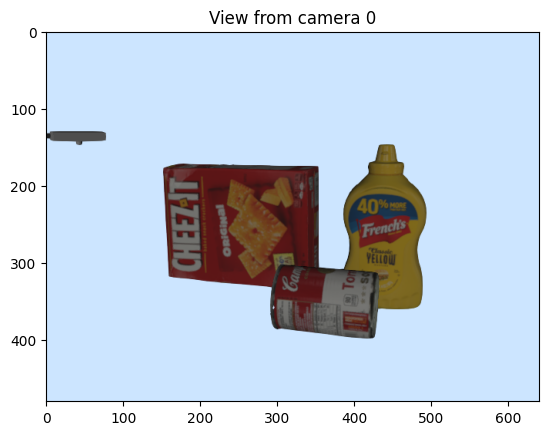

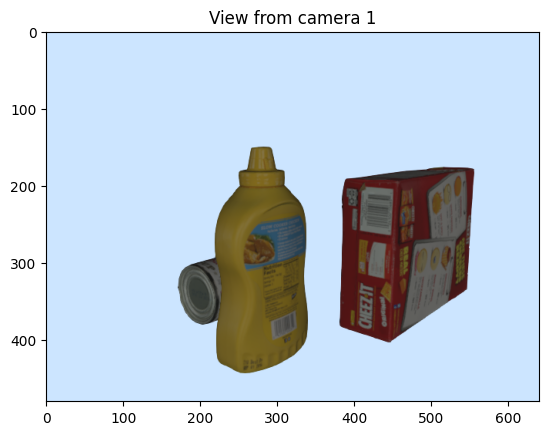

In [7]:
plt.imshow(cameras[0].rgb_im)
plt.title("View from camera 0")
plt.show()

plt.imshow(cameras[1].rgb_im)
plt.title("View from camera 1")
plt.show()

## Generate masks for each image
Now that we have a network and camera inputs, we can start processing our inputs. First, we will evaluate the mask (which is the output from our network) for each image.

In [8]:
if running_as_notebook:
    with torch.no_grad():
        predictions = []
        predictions.append(
            model([Tf.to_tensor(cameras[0].rgb_im[:, :, :3]).to(device)])
        )
        predictions.append(
            model([Tf.to_tensor(cameras[1].rgb_im[:, :, :3]).to(device)])
        )
    for i in range(2):
        for k in predictions[i][0].keys():
            if k == "masks":
                predictions[i][0][k] = (
                    predictions[i][0][k].mul(255).byte().cpu().numpy()
                )
            else:
                predictions[i][0][k] = predictions[i][0][k].cpu().numpy()
else:
    predictions = []
    for i in range(2):
        prediction = []
        prediction.append(np.load(FindDataResource("prediction_{}.npz".format(i))))
        predictions.append(prediction)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


`predictions[0]` was run on the image from Camera 0, while `predictions[1]` was run on the image from Camera 1. 

Lets take a minute to understand this output. Breaking it down by each key in the output dictionary:
* The "boxes" correspond to bounding boxes on the regions containing the object
* The "labels" tell us which class the model has associated with the (as in, whether it's the mustard bottle, the Cheez-it box, the spam container, etc. Each model is identified by a number.)
* The "scores" are a measure of confidence in the model predictions
* The "masks" are arrays which indicate which pixels belong to the corresponding class

In [9]:
predictions[0]

[{'boxes': array([[385.2136   , 146.52603  , 493.42844  , 361.93076  ],
         [  4.0501738, 130.16034  ,  77.305954 , 144.37434  ],
         [296.988    , 304.85892  , 432.53607  , 397.67767  ],
         [295.33215  , 303.01715  , 431.0152   , 398.03696  ],
         [295.0801   , 303.79337  , 428.6222   , 398.91455  ]],
        dtype=float32),
  'labels': array([3, 1, 1, 2, 3]),
  'scores': array([0.99995637, 0.9988881 , 0.62241465, 0.57202667, 0.1548783 ],
        dtype=float32),
  'masks': array([[[[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]]],
  
  
         [[[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]]],
  
  
         [[[0, 0, 0, .

The two most important elements for our task are `labels`, which tells us which class the mask corresponds to, and `mask`, which gives a higher score for pixels that more likely correspond to points on the mustard bottle.

Note that we defined `mustard_ycb_idx = 3` at the top of the notebook; that's the value of the label for the class we care about. Additionally, note that the labels are ordered according to their score, and since `np.argmax` picks the first element if there is a tie, the best fit is chosen.

The following cells visualize the masks we get:

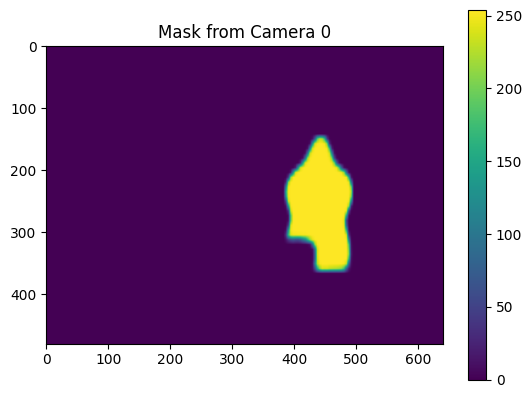

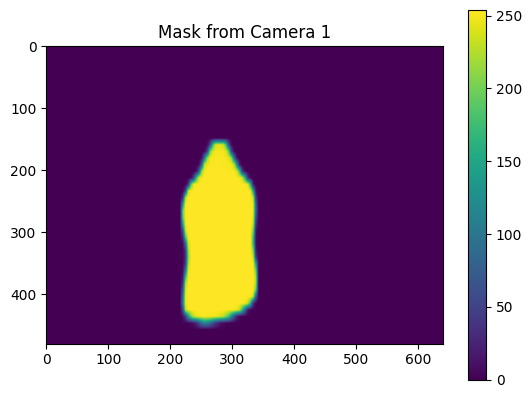

In [10]:
for i, prediction in enumerate(predictions):
    mask_idx = np.argmax(predictions[i][0]["labels"] == mustard_ycb_idx)
    mask = predictions[i][0]["masks"][mask_idx, 0]

    plt.imshow(mask)
    plt.title("Mask from Camera " + str(i))
    plt.colorbar()
    plt.show()

## Generate Point Cloud
### 9.2a Masking
Using the masks we've found, generate a filtered point cloud that includes images from both cameras but only includes points within the mustard. (You will fill in code to return both points and colors; technically, we only need the points for finding an antipodal grasp, but the colors are helpful for visualization.)

You will write code that does the following for each camera and image:
1. Extract the pixels from the mask that we consider to be within the mustard bottle (specifically: take values that are above `mask_threshold`)
2. Select points in the depth image corresponding to those pixels
3. Using the depth values, project those selected pixels back out to be points in the camera frame. You'll use the camera's `project_depth_to_pC` image to do this; refer back to problem 5.2 for how this is used.
4. Convert the points to the world frame
5. Select color values from the RGB image that correspond to your mask pixels. 

In [11]:
def get_merged_masked_pcd(
    predictions,
    rgb_ims,
    depth_ims,
    project_depth_to_pC_funcs,
    X_WCs,
    mask_threshold=150,
):
    """
    predictions: The output of the trained network (one for each camera)
    rgb_ims: RGBA images from each camera
    depth_ims: Depth images from each camera
    project_depth_to_pC_funcs: Functions that perform the pinhole camera operations to convert pixels
        into points. See the analogous function in problem 5.2 to see how to use it.
    X_WCs: Poses of the cameras in the world frame
    """

    pcd = []
    for prediction, rgb_im, depth_im, project_depth_to_pC_func, X_WC in zip(
        predictions, rgb_ims, depth_ims, project_depth_to_pC_funcs, X_WCs
    ):
        # These arrays aren't the same size as the correct outputs, but we're
        # just initializing them to something valid for now.
        spatial_points = np.zeros((3, 1))  # 3xN: (x,y,z) x Number of masked points
        rgb_points = np.zeros((3, 1))  # 3xN: Color channels x Number of masked points

        ######################################
        # Your code here (populate spatial_points and rgb_points)
        ######################################
        mask = prediction[0]["masks"][np.argmax(prediction[0]["scores"])]
        mask = (mask > mask_threshold).squeeze()

        masked_depth = depth_im[mask]
        v_indices, u_indices = np.where(mask)
        masked_pixels = np.stack([v_indices, u_indices, masked_depth], axis=-1)

        if masked_pixels.shape[0] > 0:
            points_C = project_depth_to_pC_func(masked_pixels)
            points_W = X_WC.multiply(points_C.T).T
            spatial_points = points_W.T

            rgb_points_masked = rgb_im[v_indices, u_indices, :3]
            rgb_points = (rgb_points_masked.T / 255.0).astype(np.float32)

        # You get an unhelpful RunTime error if your arrays are the wrong
        # shape, so we'll check beforehand that they're the correct shapes.
        assert (
            len(spatial_points.shape) == 2
        ), "Spatial points is the wrong size -- should be 3 x N"
        assert (
            spatial_points.shape[0] == 3
        ), "Spatial points is the wrong size -- should be 3 x N"
        assert (
            len(rgb_points.shape) == 2
        ), "RGB points is the wrong size -- should be 3 x N"
        assert (
            rgb_points.shape[0] == 3
        ), "RGB points is the wrong size -- should be 3 x N"
        assert rgb_points.shape[1] == spatial_points.shape[1]

        N = spatial_points.shape[1]
        pcd.append(PointCloud(N, Fields(BaseField.kXYZs | BaseField.kRGBs)))
        pcd[-1].mutable_xyzs()[:] = spatial_points
        pcd[-1].mutable_rgbs()[:] = rgb_points
        # Estimate normals
        pcd[-1].EstimateNormals(radius=0.1, num_closest=30)
        # Flip normals toward camera
        pcd[-1].FlipNormalsTowardPoint(X_WC.translation())

    # Merge point clouds.
    merged_pcd = Concatenate(pcd)

    # Voxelize down-sample.  (Note that the normals still look reasonable)
    return merged_pcd.VoxelizedDownSample(voxel_size=0.005)

Now let's use this function to visualize the output of `get_merged_masked_pcd`.

In [12]:
rgb_ims = [c.rgb_im for c in cameras]
depth_ims = [c.depth_im for c in cameras]
project_depth_to_pC_funcs = [c.project_depth_to_pC for c in cameras]
X_WCs = [c.X_WC for c in cameras]

pcd = get_merged_masked_pcd(
    predictions, rgb_ims, depth_ims, project_depth_to_pC_funcs, X_WCs
)
meshcat.SetObject("masked_cloud", pcd, point_size=0.003)

## Select a grasp
The following code uses your point cloud function to find an antipodal grasp, similar to an exercise on a previous problem set.

In [13]:
def find_antipodal_grasp(environment_diagram, environment_context, cameras):
    rng = np.random.default_rng()

    # Another diagram for the objects the robot "knows about": gripper, cameras, bins.  Think of this as the model in the robot's head.
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl(
        "package://manipulation/schunk_wsg_50_welded_fingers.dmd.yaml"
    )
    plant.Finalize()

    params = MeshcatVisualizerParams()
    params.prefix = "planning"
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

    rgb_ims = [c.rgb_im for c in cameras]
    depth_ims = [c.depth_im for c in cameras]
    project_depth_to_pC_funcs = [c.project_depth_to_pC for c in cameras]
    X_WCs = [c.X_WC for c in cameras]

    cloud = get_merged_masked_pcd(
        predictions, rgb_ims, depth_ims, project_depth_to_pC_funcs, X_WCs
    )

    plant_context = plant.GetMyContextFromRoot(context)
    scene_graph_context = scene_graph.GetMyContextFromRoot(context)

    min_cost = np.inf
    best_X_G = None
    for i in range(100):
        cost, X_G = GenerateAntipodalGraspCandidate(diagram, context, cloud, rng)
        if np.isfinite(cost) and cost < min_cost:
            min_cost = cost
            best_X_G = X_G

    plant.SetFreeBodyPose(plant_context, plant.GetBodyByName("body"), best_X_G)
    diagram.ForcedPublish(context)


if running_as_notebook:
    find_antipodal_grasp(environment_diagram, environment_context, cameras)

## Summary
If you take a look at Meshcat, we've reached our end goal of generating an antipodal grasp! We've now shown that we can leverage the RGB data and our trained network to filter our point clouds and get an antipodal grasp for a specific object. Now, let's think about the implications of some of the design choices we made along the way.

## Written Questions
Answer the following questions in your written submission for this problem set.

#### 9.2b Number of Cameras
Let's think back to the "Examining camera views" section. Toggling between the views of the two cameras, each of the cameras contributes different information about the scene. Why do we need the information from both of them to find antipodal grasps?

#### 9.2c Why Segment for Grasp Selection?
Our goal in this task is to grasp the mustard bottle. The first step of `get_merged_masked_pcd()` was to extract the pixels that correspond to the mustard bottle. If we skipped this step and instead considered the entire point cloud, what type of "undesirable" grasps might we select?

#### 9.2d Unsegmented Point Cloud
In this notebook, after we mask the point clouds based on the segmentation results, we don't use the other point clouds again (including when we evaluate our grasp candidates). Think about how we have checked whether or not a grasp is feasible. How might discarding the point cloud data for the other objects inadvertently lead us to select an invalid grasp?

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `segmentation_and_grasp.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.
- Answer parts (b) through (d) in the written section of Gradescope as a part of your `pdf` submission. 

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [4 pts] `get_merged_masked_pcd` must be implemented correctly. 
- [2 pts] Correct answer for 9.2b
- [2 pts] Correct answer for 9.2c
- [2 pts] Correct answer for 9.2d

In [15]:
from manipulation.exercises.grader import Grader
from manipulation.exercises.segmentation.test_segmentation_and_grasp import (
    TestSegmentationAndGrasp,
)

Grader.grade_output([TestSegmentationAndGrasp], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 4/4.

Score for Test find_antipodal_pts is 4/4.
- /usr/local/lib/python3.10/dist-packages/book/data/segmentation_and_grasp_soln.npz was not found locally; downloading it now...



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dbd3efd9-6570-475d-9e28-dfec82f78a4a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>